In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we show how to train an unsupervised model using the [Barlow Twins](https://arxiv.org/pdf/2103.03230) architecture on the datasets generated in the previous notebook.

# Dataset

Datasets for unsupervised training.

In [45]:
from src.dm import DataModule

# dm = DataModule('/fastdata/Satellogic/data/tifs/satellogic', batch_size=5)
dm = DataModule('/fastdata/Satellogic/data/tifs/sentinel2', batch_size=5, bands=(4,3,2,8))
dm.setup()

Unsupervised
Number of images: 260177


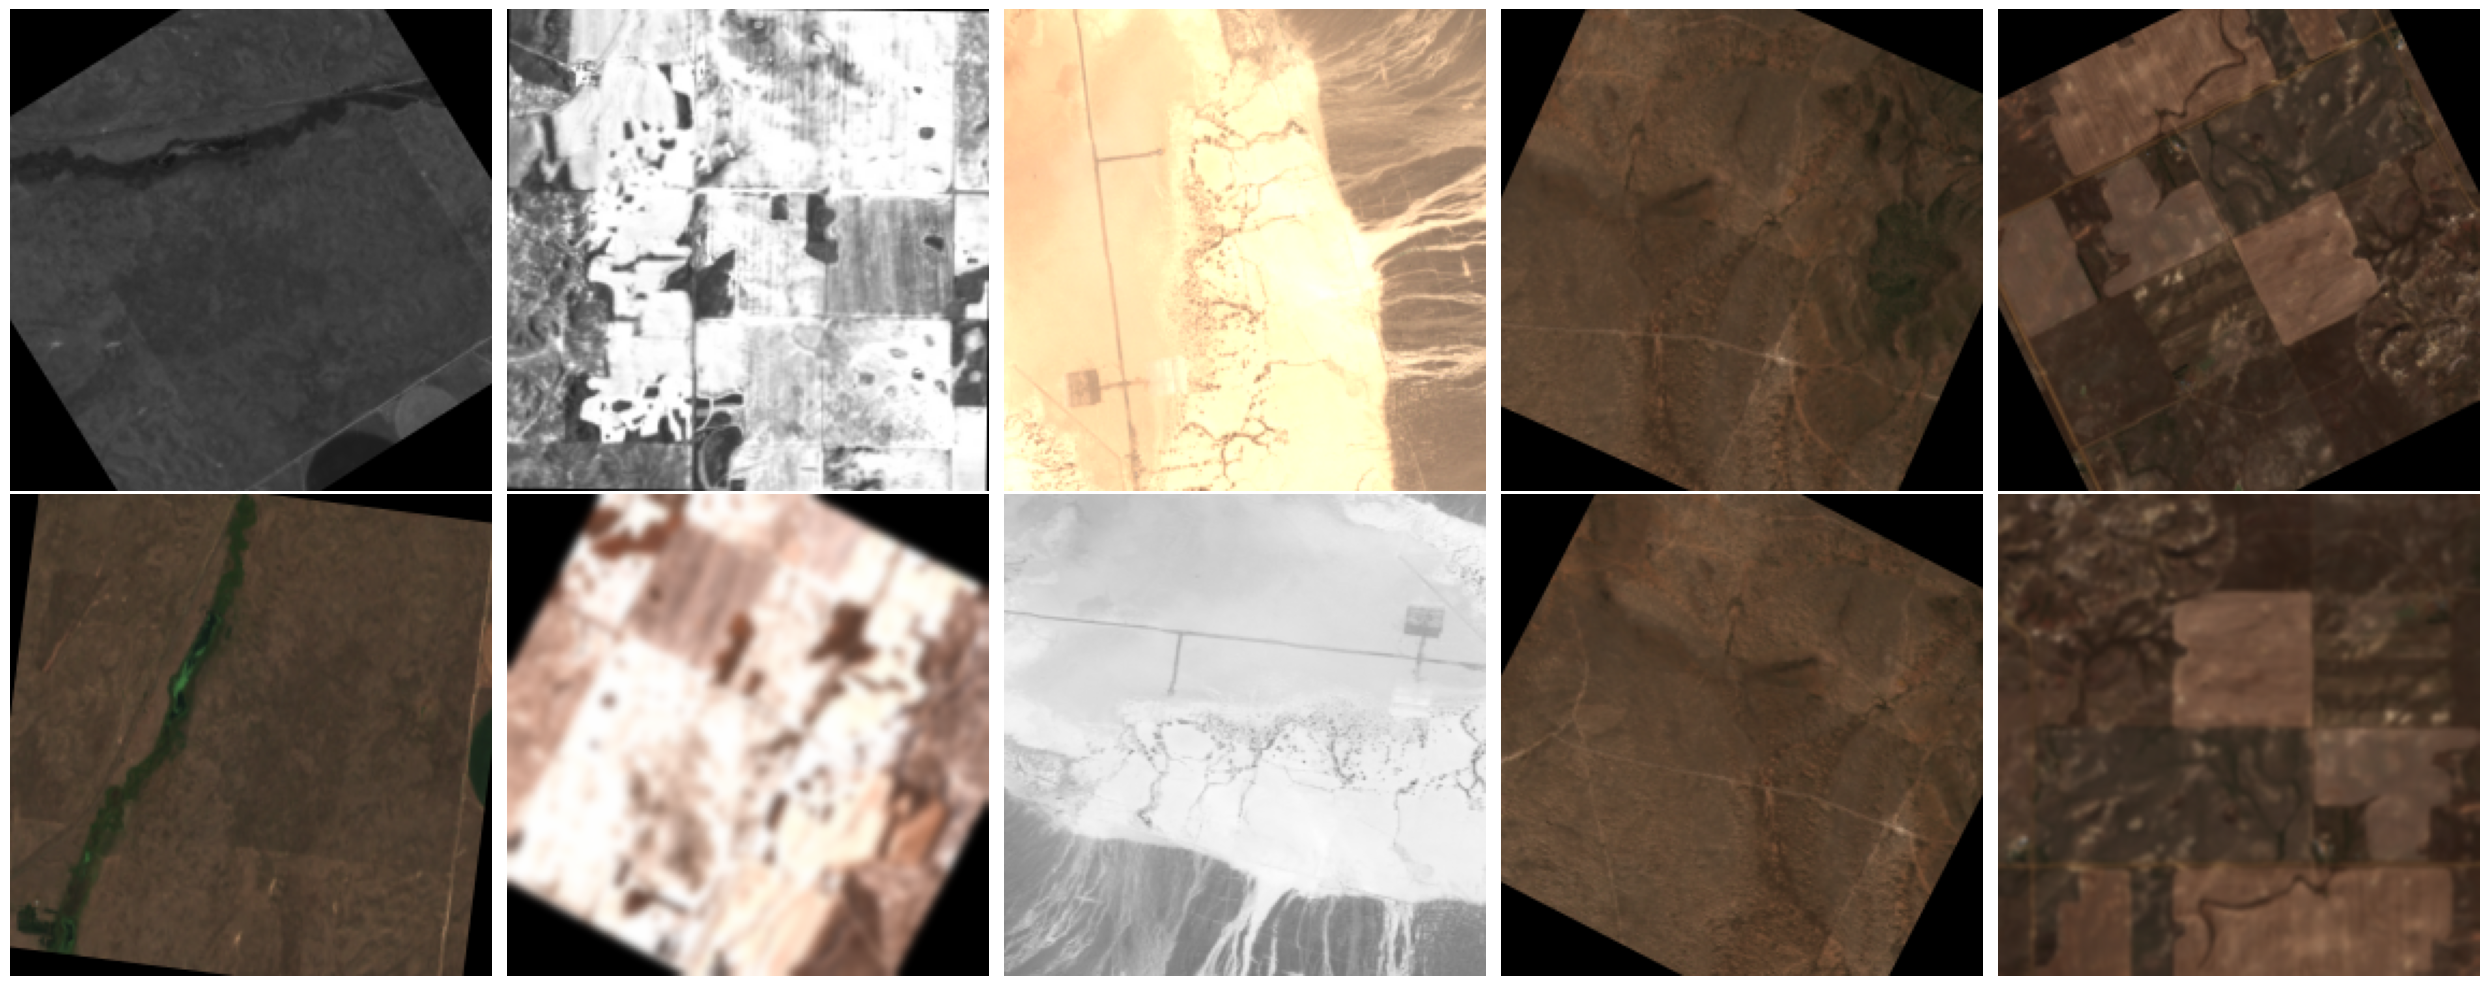

: 

In [ ]:
import matplotlib.pyplot as plt

batch = next(iter(dm.train_dataloader()))
images1, images2 = batch
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for i in range(5):
    img = images1[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    img = images2[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(img[..., :3])
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [4]:
dm = DataModule('/fastdata/Satellogic/data/tifs/sentinel2', batch_size=5, bands=(4,3,2,8))
dm.setup()

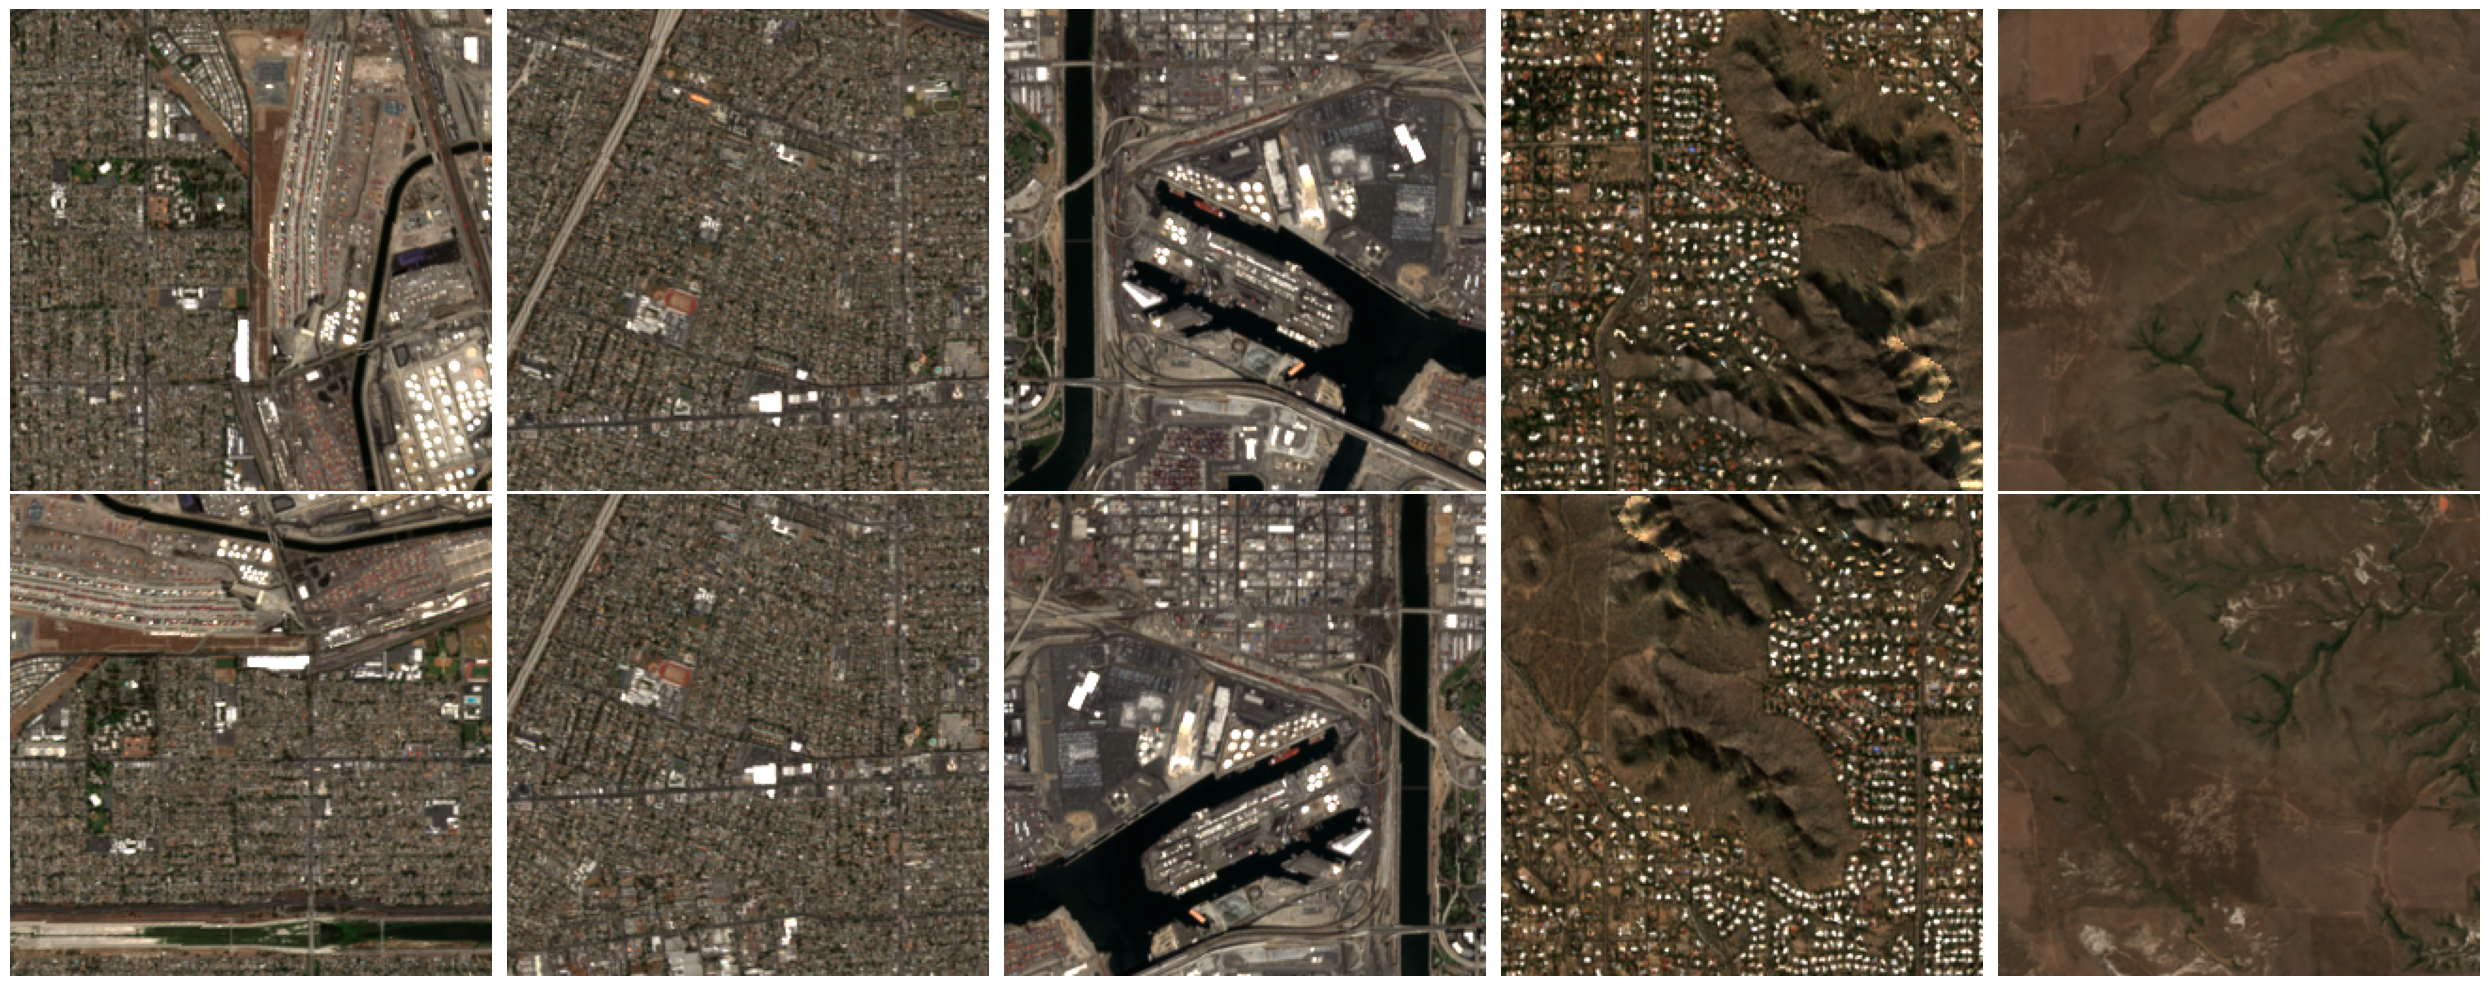

In [5]:
batch = next(iter(dm.train_dataloader()))
images1, images2 = batch
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
for i in range(5):
    img = images1[i].permute(1, 2, 0).numpy()
    axes[0, i].imshow(img[..., :3])
    axes[0, i].axis('off')
for i in range(5):
    img = images2[i].permute(1, 2, 0).numpy()
    axes[1, i].imshow(img[..., :3])
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

For evaluating the model during and after training with Sentinel 2 images, we will use the [EuroSAT dataset](https://www.eotdl.com/datasets/EuroSAT).

In [6]:
from src.dm import EuroSATDataModule

dm = EuroSATDataModule('/fastdata/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif', batch_size=25, bands=(4,3,2,8))
dm.setup()

Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  21600
Validation samples:  5400


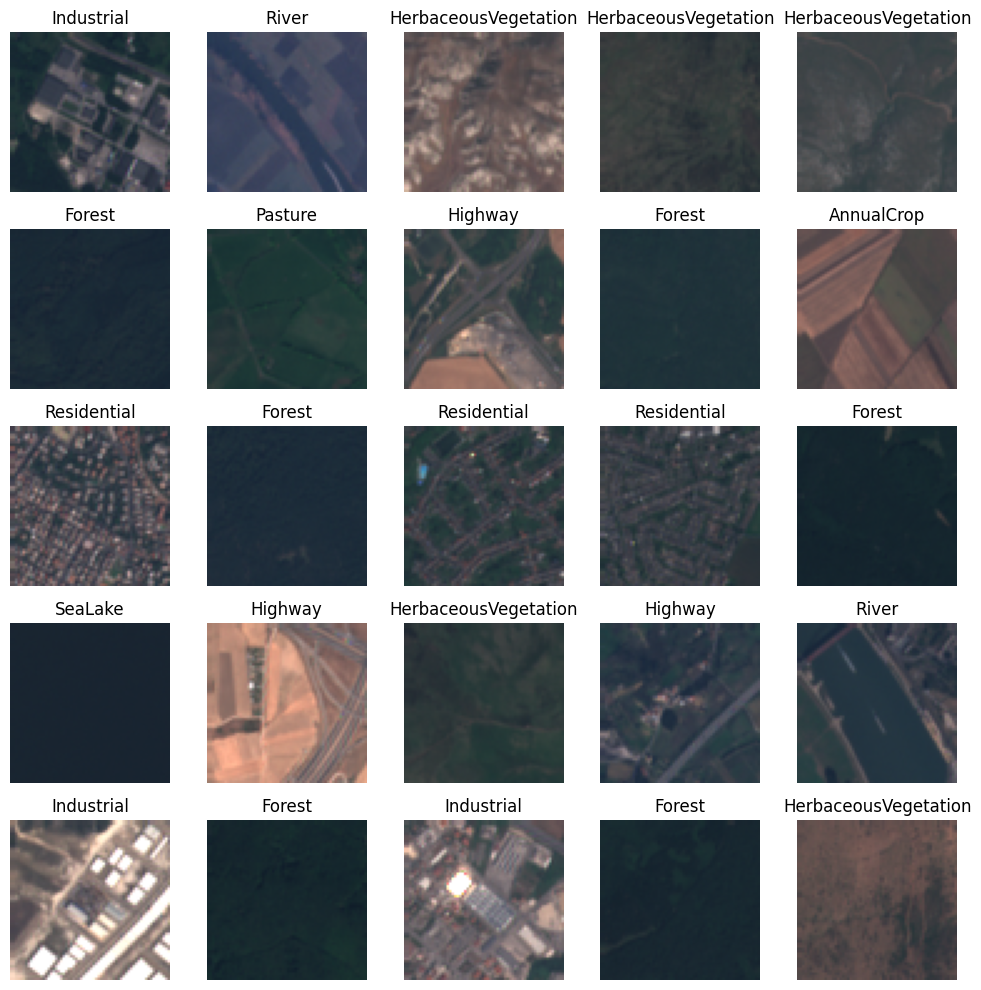

In [7]:
batch = next(iter(dm.train_dataloader()))
images, labels = batch
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(images):
            img = images[idx].permute(1, 2, 0).numpy()
            axes[i, j].imshow(img[..., :3])
            axes[i, j].set_title(f'{dm.labels[labels[idx]]}')
            axes[i, j].axis('off')
plt.tight_layout()
plt.show()

A similar process should be followed for the Sentinel 1 and Satellogic, although labeled Satellogic images are not very common.

# Model

In [8]:
from src.module import Module

config = {
    'backbone': 'resnet18',
    'mlp_dim': 2048,
    'in_chans': 4
}

module = Module(config)

output = module(images1)
output.shape


torch.Size([5, 2048])

When pretraining with Sentinel 2 images, we will evaluate the model on the EuroSAT dataset.

In [9]:
from src.module import EuroSATModule

config = {
    'freeze': True,
    'num_classes': 10
}

module2 = EuroSATModule(config, module.backbone)

output = module2(images)
output.shape

torch.Size([25, 10])

# Training

In [10]:
import lightning as L

dm = DataModule(
    '/fastdata/Satellogic/data/tifs/satellogic', 
    batch_size=25, 
    bands=(1,2,3,4)
)

module = Module({
    'backbone': 'resnet18',
    'mlp_dim': 2048,
    'in_chans': 4
})

trainer =L.Trainer(
    max_epochs=5,
    accelerator='gpu',
    devices=1,
    limit_train_batches=10,
    enable_checkpointing=False,
    logger=False,
)

# trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


When pretraining with Sentinel 2 images, we will evaluate the model on the EuroSAT dataset.

In [12]:
from src.cbs import SSLOnlineEvaluator

dm = DataModule(
    '/fastdata/Satellogic/data/tifs/sentinel2', 
    batch_size=25, 
    bands=(4,3,2,8)
)

trainer =L.Trainer(
    max_epochs=6,
    accelerator='gpu',
    devices=1,
    limit_train_batches=10,
    enable_checkpointing=False,
    logger=False,
    callbacks=[
        SSLOnlineEvaluator(
            '/fastdata/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif', 
            bands=(4,3,2,8), 
            head_epochs=10, 
            eval_period=2
        )
    ]
)

trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | backbone | FeatureListNet | 11.2 M | eval 
1 | head     | Sequential     | 9.5 M  | train
----------------------------------------------------
9.5 M     Trainable params
11.2 M    Non-trainable params
20.6 M    Total params
82.525    Total estimated model params size (MB)
10        Modules in train mode
90        Modules in eval mode


Generating images and labels ...
Number of images: 27000
Generating train / val splits ...
Training samples:  21600
Validation samples:  5400


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

You can find a complete working example in the `train.py` script.

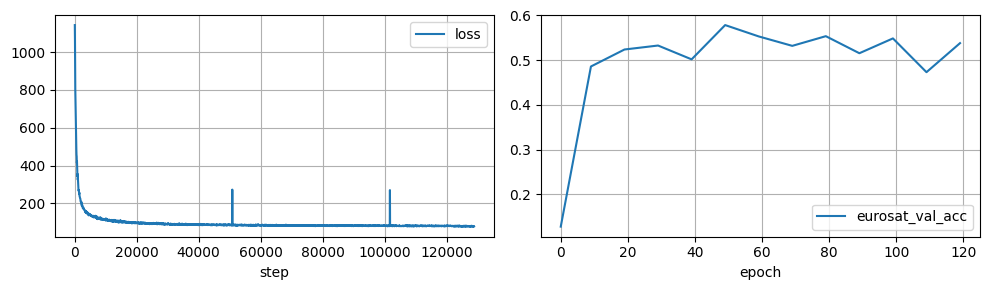

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/usecaseA'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/usecaseA/{last_version}/metrics.csv')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.dropna(subset=['loss']).plot(x='step', y='loss', kind='line', ax=axs[0], grid=True)
metrics.dropna(subset=['eurosat_val_acc']).plot(x='epoch', y='eurosat_val_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

# Export

TODO

# Ingest to EOTDL

TODO